<font size="6"> **Model Building: Linear Models** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")
pd.set_option('precision', 4)

In [3]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)

In [4]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

In [5]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(OUTPATH + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(OUTPATH + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [6]:
(y_train_smp>0).value_counts()

True     24373
False    18948
Name: target, dtype: int64

# Ridge Weekly Sampling

## Hyperaparameter Tunning

In [7]:
hpgrid_ridge = {'alpha': [10.0**x for x in range(-3,3)]}

In [8]:
ridge_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [9]:
ridge_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_smp, return_train_score=True)
res_ridge_cv = ridge_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [10]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

In [11]:
ridge_params_df = pd.DataFrame(res_ridge_cv.cv_results_['params'])
ridge_metrics_df = pd.DataFrame(res_ridge_cv.cv_results_)[select_sum_cols]
ridge_sum_df = ridge_params_df.join(ridge_metrics_df)
ridge_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
1,0.010,0.4536,0.0308,1,0.5476,0.5741,0.5205,-0.0289
2,0.100,0.4504,0.0276,2,0.5733,0.7279,0.3671,-0.0283
0,0.001,0.4431,0.0413,3,0.5542,0.6587,0.4277,-0.0288
3,1.000,0.4387,0.0363,4,0.5604,0.7202,0.3418,-0.0289
4,10.000,0.4311,0.0353,5,0.5589,0.7513,0.3014,-0.0283
5,100.000,0.3929,0.0176,6,0.5446,0.8755,0.1334,-0.0284


In [12]:
select_cvdet_cols = ['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy', 'mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                    'mean_test_accuracy', 'mean_test_neg_root_mean_squared_error']

In [13]:
ridge_metrics_cvdet =  pd.DataFrame(res_ridge_cv.cv_results_)[select_cvdet_cols]
ridge_metrics_cvdet['alpha'] = ridge_params_df['alpha']

In [14]:
champ_ridge_idx = 3
champ_ridge_hparms = res_ridge_cv.cv_results_['params'][champ_ridge_idx]
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**champ_ridge_hparms)
champ_ridge.fit(X_train_smp, y_train_smp)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [15]:
champ_ridge_score = ridge_metrics_cvdet.loc[champ_ridge_idx,'mean_test_w_accuracy']
champ_ridge_alpharank = ridge_metrics_cvdet.loc[champ_ridge_idx, 'alpha']
top_ridge_score = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
top_ridge_alpharank = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'alpha'].iloc[0]
champ_ridge_score, champ_ridge_alpharank, top_ridge_score, top_ridge_alpharank

(0.43866710863130115, 1.0, 0.45357045192830037, 0.01)

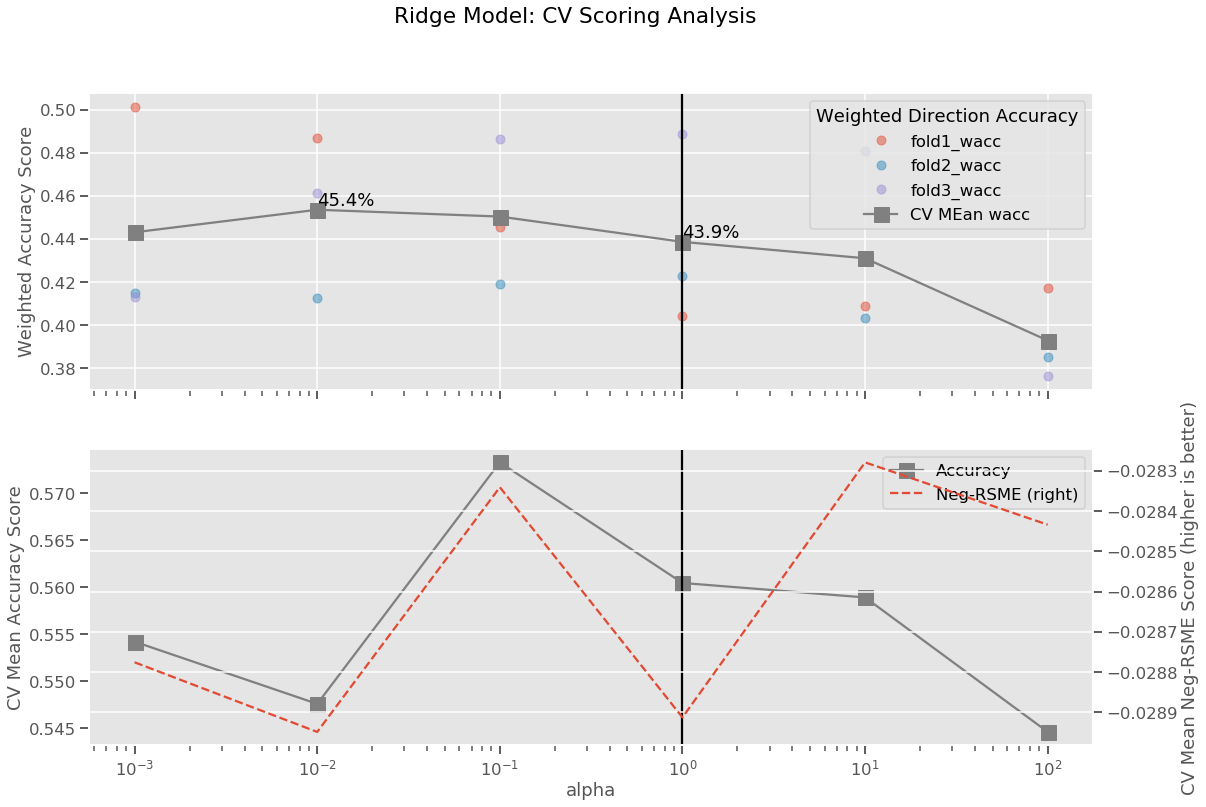

In [16]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Ridge Model: CV Scoring Analysis")
ax = axs[0]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        logx=True, style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_w_accuracy',
                        logx=True, marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(top_ridge_alpharank, top_ridge_score, f'{top_ridge_score:0.1%}', va='bottom', ha='left')
ax.text(champ_ridge_alpharank, champ_ridge_score, f'{champ_ridge_score:0.1%}', va='bottom', ha='left')

ax = axs[1]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        logx=True,marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--',
                        logx=True)

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')

for ax in axs:
    ax.axvline(x=champ_ridge_alpharank, color='black')
    
plt.show()


There are several models that may be nice to select, model ranked 2 (alpha=0.1) is a good choice:
* Hyperparameter Discusion:
    * `alpha=0.1`: Alpha is a regularization parameter, the higher its value, the more that model coefficient shrinked, when alpha=0, Ridge model is the same as a regular Linear Regression. Increasing alpha allows the model to accomodate slightly correlated features as well as, avoiding overfitting
* The best performant model is at `alpha=1`, however, cv score yield the highest standard deviation, that means that in test dataset, this score estimation may not be accurate.
* On the other hand, higher regularization means that the model tends to generalize better. However, looking at `fold2_wacc`, it is the best among any alpha, that means that `alpha=1` is the best only for that fold, skewing the mean cv. Better to look at other models


# Ridge Full Dataset

## Hyperaparameter Tunning

In [17]:
ridge_tscv_full = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full)
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [18]:
ridge_full_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_full, return_train_score=True)
res_ridge_full_cv = ridge_full_cv.fit(X_train_full, y_train_full)

## CV Grid Search Analysis

In [19]:
ridge_full_params_df = pd.DataFrame(res_ridge_full_cv.cv_results_['params'])
ridge_full_metrics_df = pd.DataFrame(res_ridge_full_cv.cv_results_)[select_sum_cols]
ridge_full_sum_df = ridge_params_df.join(ridge_full_metrics_df)
ridge_full_sum_df.sort_values(by='rank_test_w_accuracy')

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
3,1.000,0.4468,0.0195,1,0.5703,0.7280,0.3594,-0.0284
2,0.100,0.4399,0.0190,2,0.5255,0.5133,0.5532,-0.0299
4,10.000,0.4339,0.0294,3,0.5566,0.7215,0.3314,-0.0288
1,0.010,0.4282,0.0333,4,0.5237,0.5624,0.4872,-0.0296
5,100.000,0.4190,0.0172,5,0.5541,0.7800,0.2571,-0.0283
0,0.001,0.4077,0.0313,6,0.5440,0.7756,0.2404,-0.0316


In [20]:
ridge_full_metrics_cvdet =  pd.DataFrame(res_ridge_full_cv.cv_results_)[select_cvdet_cols]
ridge_full_metrics_cvdet['alpha'] = ridge_full_params_df['alpha']

# Ridge Non-Overlapping Sample: Voting Ensemble

## Hyperparameter Tunning

In [21]:
ridge_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [22]:
ridge_nov_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_smp, return_train_score=True)
res_ridge_nov_cv = ridge_nov_cv.fit(X_train_smp[features_nov], y_train_smp)

## CV Grid Search Analysis

In [23]:
ridge_nov_params_df = pd.DataFrame(res_ridge_nov_cv.cv_results_['params'])
ridge_nov_metrics_df = pd.DataFrame(res_ridge_nov_cv.cv_results_)[select_sum_cols]
ridge_nov_sum_df = ridge_params_df.join(ridge_nov_metrics_df)
ridge_nov_sum_df.sort_values(by='rank_test_w_accuracy')

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
2,0.100,0.4483,0.0289,1,0.5729,0.7377,0.3536,-0.0284
1,0.010,0.4450,0.0276,2,0.5308,0.5202,0.5539,-0.0297
3,1.000,0.4385,0.0362,3,0.5615,0.7271,0.3358,-0.0295
4,10.000,0.4320,0.0415,4,0.5606,0.7606,0.2936,-0.0284
0,0.001,0.4303,0.0348,5,0.5305,0.5893,0.4668,-0.0293
5,100.000,0.3925,0.0198,6,0.5494,0.9083,0.1031,-0.0284


In [24]:
ridge_nov_metrics_cvdet =  pd.DataFrame(res_ridge_nov_cv.cv_results_)[select_cvdet_cols]
ridge_nov_metrics_cvdet['alpha'] = ridge_nov_params_df['alpha']

## Benchmarking

In [25]:
ridge_params = list(hpgrid_ridge.keys())
ridge_metrics = ['std_test_w_accuracy', 'mean_test_w_accuracy', 'rank_test_w_accuracy']

ridge_sum_join_df = ridge_sum_df[ridge_params + ridge_metrics].set_index('rank_test_w_accuracy').join(
    ridge_nov_sum_df[ridge_params +  ridge_metrics].set_index('rank_test_w_accuracy'),
        lsuffix='_smp', rsuffix='_nov').join(
    ridge_full_sum_df[ridge_params +  ridge_metrics].set_index('rank_test_w_accuracy').add_suffix("_full"))

ridge_sum_join_top_df = ridge_sum_join_df.sort_values(by='rank_test_w_accuracy').head(10)
ridge_sum_join_top_df

,alpha_smp,std_test_w_accuracy_smp,mean_test_w_accuracy_smp,alpha_nov,std_test_w_accuracy_nov,mean_test_w_accuracy_nov,alpha_full,std_test_w_accuracy_full,mean_test_w_accuracy_full
rank_test_w_accuracy,,,,,,,,,
1,0.010,0.0308,0.4536,0.100,0.0289,0.4483,1.000,0.0195,0.4468
2,0.100,0.0276,0.4504,0.010,0.0276,0.4450,0.100,0.0190,0.4399
3,0.001,0.0413,0.4431,1.000,0.0362,0.4385,10.000,0.0294,0.4339
4,1.000,0.0363,0.4387,10.000,0.0415,0.4320,0.010,0.0333,0.4282
5,10.000,0.0353,0.4311,0.001,0.0348,0.4303,100.000,0.0172,0.4190
6,100.000,0.0176,0.3929,100.000,0.0198,0.3925,0.001,0.0313,0.4077


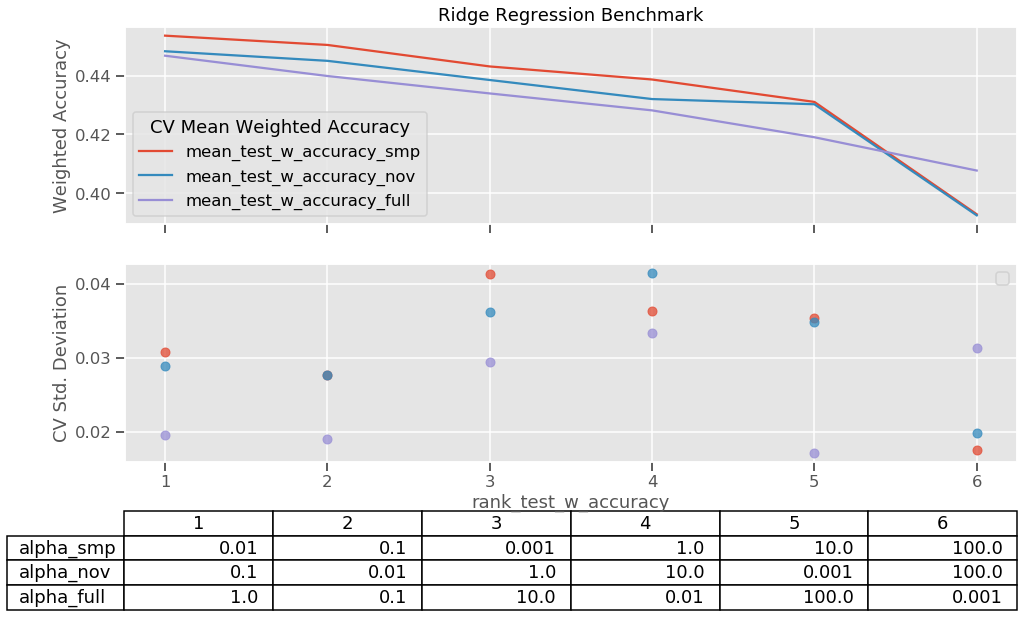

In [26]:
fig, axs = plt.subplots(2,1, sharex=True)

ax =  axs[0]
ridge_sum_join_top_df.filter(regex='^mean_').plot(ax=ax, label=['sample', 'sample no weekday (nov)', 'full'])
ax.legend(title='CV Mean Weighted Accuracy')
ax.set_ylabel('Weighted Accuracy')
ax.set_title("Ridge Regression Benchmark")

ax =  axs[1]
ax = ridge_sum_join_top_df.filter(regex='^std_').plot(ax=ax, style='o', alpha=0.75)
ax.legend("")
ax.set_ylabel('CV Std. Deviation')


ridge_params_cols = [x for x in ridge_sum_join_top_df.columns if x[:x.rfind("_")] in ridge_params]
colors = [[ax.get_lines()[i].get_color()]*len(ridge_params) for i in range(0,3)]

ridge_benchmark_tb = plt.table(cellText=ridge_sum_join_top_df[ridge_params_cols].T.astype(str).values,
                      rowLabels=ridge_params_cols,
                      colLabels=ridge_sum_join_top_df.index,
                      loc='bottom',bbox=[0., -.75, 1., .5])#[left, bottom, width , height]

ridge_benchmark_tb.auto_set_font_size(True)


plt.show()

## Experimental Ensemble

In [27]:
hparams_ridge = {'alpha': 1.}

In [28]:
ridge = Ridge(fit_intercept=False, random_state=RND_SEED, **hparams_ridge)

In [29]:
ridge_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=ridge, n_skip_samples=4)
ridge_nov.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=Ridge(alpha=1.0, copy_X=True,
                                             fit_intercept=False, max_iter=None,
                                             normalize=False, random_state=123,
                                             solver='auto', tol=0.001),
                        n_skip_samples=4)

### Correlation over voter

In [30]:
ridge_voters = ridge_nov.estimators_

In [31]:
x_train_subsets = []
y_pred_subsets = []
n_rows = 1e6
for weekday in range(0, 4+1):
    x = X_train_full.loc[X_train_full[f'weekday_{weekday}']==1, features_nov]
    p = ridge_voters[weekday].predict(x)
    n_rows = min(n_rows, len(p))
    x_train_subsets.append(x)
    y_pred_subsets.append(p[:n_rows])


In [32]:
nov_weekday_preds = np.column_stack(y_pred_subsets)
pd.DataFrame(nov_weekday_preds).corr()

,0,1,2,3,4
0,1.0000,0.0287,0.1778,0.0227,0.0803
1,0.0287,1.0000,0.5989,0.4238,0.4128
2,0.1778,0.5989,1.0000,0.6466,0.6290
3,0.0227,0.4238,0.6466,1.0000,0.7102
4,0.0803,0.4128,0.6290,0.7102,1.0000


# Write Reports

In [33]:
benchmark_path = OUTPATH + "benchmark" + "/"

ridge_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_smp_summary.csv")
ridge_full_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_full_summary.csv")
ridge_nov_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_nov_summary.csv")

ridge_sum_join_df.to_csv(benchmark_path + "ridge_benchmark.csv")
ridge_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_smp_cvdet.csv")
ridge_full_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_full_cvdet.csv")
ridge_nov_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "ridge_nov_cvdet.csv")